In [1]:
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


In [ ]:
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.nn import BCELoss
import torch.nn.functional as F
import torchvision
from torchvision import models
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import default_collate
from torchvision import transforms
from torch import sigmoid
from PIL import Image

In [ ]:
USE_GPU = True
device = torch.device('cpu')

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [ ]:
!mkdir anime_photo_without_smoothing
!mkdir anime_photo_without_smoothing/1
!unzip -n -q /content/data/My\ Drive/cartoonGAN/safebooru.zip -d anime_photo_without_smoothing/1/

In [ ]:
image_size = 256
batch_size = 16

transformer = transforms.Compose([
    transforms.CenterCrop(image_size),
    transforms.ToTensor() # ToTensor() changes the range of the values from [0, 255] to [0.0, 1.0]
])

anime_dataset = ImageFolder('anime_photo_without_smoothing/', transformer)
len_training_set = math.floor(len(anime_dataset) * 0.9)
len_valid_set = len(anime_dataset) - len_training_set

training_set, _ = random_split(anime_dataset, (len_training_set, len_valid_set))
anime_image_dataloader_train = DataLoader(training_set, batch_size, shuffle=True, num_workers=0)

In [ ]:
# experiment on fixing data not found

# Define the SafeImageFolder class
class SafeImageFolder(ImageFolder):
    def __getitem__(self, index):
        try:
            return super().__getitem__(index)
        except FileNotFoundError as e:
            print(f"File not found: {e}. Skipping...")
            return None

# Define a safe collate function that filters out None values
def safe_collate(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return torch.Tensor()
    return default_collate(batch)

# Set up your transformations
image_size = 256
transformer = transforms.Compose([
    transforms.CenterCrop(image_size),
    transforms.ToTensor()
])

# Instantiate the dataset using SafeImageFolder
anime_dataset = SafeImageFolder('anime_photo_without_smoothing/', transformer)

# Split the dataset into training and validation sets
len_training_set = math.floor(len(anime_dataset) * 0.9)
len_valid_set = len(anime_dataset) - len_training_set
training_set, _ = random_split(anime_dataset, (len_training_set, len_valid_set))

# Create the data loader for the training set
anime_image_dataloader_train = DataLoader(
    training_set,
    batch_size=16,
    shuffle=True,
    num_workers=0,
    collate_fn=safe_collate  # Apply the safe collate function here
)

torch.Size([3, 256, 256])
Current range: 0.007843137718737125 to 1.0


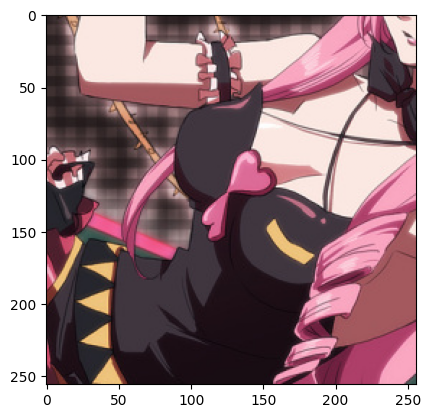

In [ ]:
def show_sample_image(dataloader):
  iterator = iter(dataloader)
  sample_batch, _ = next(iterator)
  first_sample_image_of_batch = sample_batch[0]
  print(first_sample_image_of_batch.size())
  print("Current range: {} to {}".format(first_sample_image_of_batch.min(), first_sample_image_of_batch.max()))
  plt.imshow(np.transpose(first_sample_image_of_batch.numpy(), (1, 2, 0)))

show_sample_image(anime_image_dataloader_train)

In [ ]:
!mkdir anime_photo_smoothing
!mkdir anime_photo_smoothing/1
!unzip -n -q /content/data/My\ Drive/cartoonGAN/safebooru_smoothed.zip -d anime_photo_smoothing/1/ #extract to subfolder due to DataLoader needs subdirectories

torch.Size([3, 256, 256])
Current range: 0.019607843831181526 to 1.0


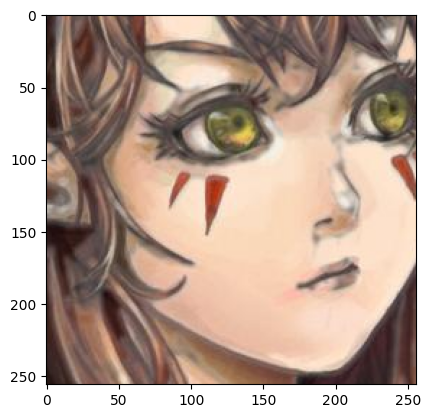

In [ ]:
smoothed_anime_dataset = ImageFolder('anime_photo_smoothing/', transformer)
len_training_set = math.floor(len(smoothed_anime_dataset) * 0.9)
len_valid_set = len(smoothed_anime_dataset) - len_training_set
training_set, _ = random_split(smoothed_anime_dataset, (len_training_set, len_valid_set))
smoothed_anime_image_dataloader_train = DataLoader(training_set, batch_size, shuffle=True, num_workers=0)

show_sample_image(smoothed_anime_image_dataloader_train)

In [ ]:
!mkdir photos
!mkdir photos/1
!unzip -n -q /content/data/My\ Drive/cartoonGAN/coco.zip -d photos/1 #extract to subfolder due to DataLoader needs subdirectories

torch.Size([3, 256, 256])
Current range: 0.0 to 1.0


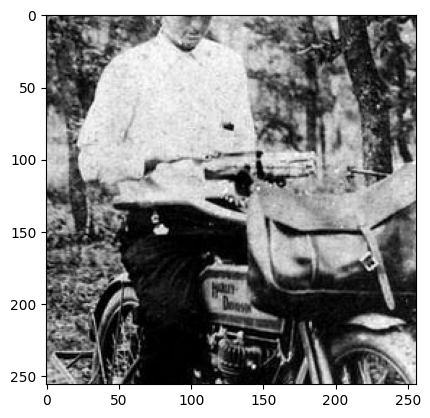

In [ ]:
photo_dataset = ImageFolder('photos/', transformer)
len_training_set = math.floor(len(photo_dataset) * 0.9)
len_valid_set = len(photo_dataset) - len_training_set
training_set, validation_set = random_split(photo_dataset, (len_training_set, len_valid_set))
photo_dataloader_train = DataLoader(training_set, batch_size, shuffle=True, num_workers=0)
photo_dataloader_valid = DataLoader(validation_set, batch_size, shuffle=True, num_workers=0)

show_sample_image(photo_dataloader_train)

In [ ]:
!mkdir /content/data/My\ Drive/cartoonGAN/tensorboard/

mkdir: cannot create directory ‘/content/data/My Drive/cartoonGAN/tensorboard/’: File exists


In [ ]:
%tensorflow_version 2

from torch.utils.tensorboard import SummaryWriter

tensorboard_logdir = '/content/data/My Drive/cartoonGAN/tensorboard'
writer = SummaryWriter(tensorboard_logdir)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self):
    super(ResidualBlock, self).__init__()
    self.layer = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256)
    )

  def forward(self, x):
    out = self.layer(x)
    return out + x

class Generator(nn.Module):
    def __init__(self):
      super(Generator, self).__init__()
      self.layer1 = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=1, padding=3),
          nn.BatchNorm2d(64),
          nn.ReLU()
      )

      # Down Sampling
      self.layer2 = nn.Sequential(
          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
          nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU()
      )

      self.layer3 = nn.Sequential(
          nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
          nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(256),
          nn.ReLU()
      )

      residualBlocks = []
      for l in range(8):
        residualBlocks.append(ResidualBlock())
      self.res = nn.Sequential(*residualBlocks)

      # Up Sampling
      self.layer4 = nn.Sequential(
          nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
          nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU()
      )

      self.layer5 = nn.Sequential(
          nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
          nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(in_channels=64, out_channels=3, kernel_size=7, stride=1, padding=3)
      )

    def forward(self, x):

      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)

      x = self.res(x)

      x = self.layer4(x)
      x = self.layer5(x)

      # use sigmoid to ensure the output pixels are normalized between 0 and 1
      x = sigmoid(x)

      return x

G = Generator()

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
     super(Discriminator, self).__init__()

     self.layer1 = nn.Sequential(
         nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
         nn.LeakyReLU(negative_slope=0.2)
     )

     self.layer2 = nn.Sequential(
         nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
         nn.LeakyReLU(negative_slope=0.2),
         nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
         nn.BatchNorm2d(128),
         nn.LeakyReLU(negative_slope=0.2),
     )

     self.layer3 = nn.Sequential(
         nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1),
         nn.LeakyReLU(negative_slope=0.2),
         nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
         nn.BatchNorm2d(256),
         nn.LeakyReLU(negative_slope=0.2),
     )

     self.layer4 = nn.Sequential(
         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
         nn.BatchNorm2d(256),
         nn.LeakyReLU(negative_slope=0.2),
     )

     self.last_conv = nn.Conv2d(in_channels=256, out_channels=1, kernel_size=3, stride=1, padding=1)

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.last_conv(x)
    x = sigmoid(x)
    return x

D = Discriminator()

In [ ]:
G.to(device)
D.to(device)

Discriminator(
  (conv_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_7): Conv2d(256, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
path_to_pretrained_vgg16 = '/content/data/My Drive/cartoonGAN/vgg16-397923af.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
torch.save(vgg16.state_dict(), path_to_pretrained_vgg16)
vgg16 = vgg16.to(device)

feature_extractor = vgg16.features[:24]
for param in feature_extractor.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 187MB/s]


In [ ]:
class DiscriminatorLoss(torch.nn.Module):
  def __init__(self):
      super(DiscriminatorLoss, self).__init__()
      self.bce_loss = BCELoss()

  def forward(self, discriminator_output_of_anime_input,
              discriminator_output_of_anime_smoothed_input,
              discriminator_output_of_generated_image_input,
              epoch,
              write_to_tensorboard=False):

    return self._adversarial_loss(discriminator_output_of_anime_input,
                     discriminator_output_of_anime_smoothed_input,
                     discriminator_output_of_generated_image_input,
                     epoch,
                     write_to_tensorboard)

  def _adversarial_loss(self, discriminator_output_of_anime_input,
                     discriminator_output_of_anime_smoothed_input,
                     discriminator_output_of_generated_image_input,
                     epoch,
                     write_to_tensorboard):

    actual_batch_size = discriminator_output_of_anime_input.size()[0]
    zeros = torch.zeros([actual_batch_size, 1, 64, 64]).to(device)
    ones = torch.ones([actual_batch_size, 1, 64, 64]).to(device)

    d_loss_anime = self.bce_loss(discriminator_output_of_anime_input, ones)
    d_loss_anime_smoothed = self.bce_loss(discriminator_output_of_anime_smoothed_input, zeros)
    d_loss_generated_input = self.bce_loss(discriminator_output_of_generated_image_input, zeros)

    d_loss = d_loss_anime + d_loss_anime_smoothed + d_loss_generated_input

    if write_to_tensorboard:
      writer.add_scalar('d_loss_anime', d_loss_anime,epoch)
      writer.add_scalar('d_loss_anime_smoothed', d_loss_anime_smoothed, epoch)
      writer.add_scalar('d_loss_generated_input', d_loss_generated_input, epoch)
      writer.add_scalar('d_loss', d_loss, epoch)

    return d_loss

In [ ]:
class GeneratorLoss(torch.nn.Module):
  def __init__(self):
      super(GeneratorLoss, self).__init__()
      self.w = 0.000005
      self.bce_loss = BCELoss()
      self.feature_extractor = vgg16.features[:24]
      for param in self.feature_extractor.parameters():
        param.require_grad = False

  def forward(self, discriminator_output_of_generated_image_input,
              generator_input,
              generator_output,
              epoch,
              is_init_phase=False,
              write_to_tensorboard=False):
    if is_init_phase:
      g_content_loss = self._content_loss(generator_input, generator_output)
      g_adversarial_loss = 0.0
      g_loss = g_content_loss
    else:
      g_adversarial_loss = self._adversarial_loss_generator_part_only(discriminator_output_of_generated_image_input)
      g_content_loss = self._content_loss(generator_input, generator_output)
      g_loss = g_adversarial_loss + self.w * g_content_loss

    if write_to_tensorboard:
      writer.add_scalar('g_adversarial_loss', g_adversarial_loss, epoch)
      writer.add_scalar('g_content_loss', g_content_loss, epoch)
      writer.add_scalar('g_loss', g_loss, epoch)

    return g_loss

  def _adversarial_loss_generator_part_only(self, discriminator_output_of_generated_image_input):
    actual_batch_size = discriminator_output_of_generated_image_input.size()[0]
    ones = torch.ones([actual_batch_size, 1, 64, 64]).to(device)
    return self.bce_loss(discriminator_output_of_generated_image_input, ones)

  def _content_loss(self, generator_input, generator_output):
    return (self.feature_extractor(generator_output) - self.feature_extractor(generator_input)).norm(p=1)

In [ ]:
discriminatorLoss = DiscriminatorLoss()
generatorLoss = GeneratorLoss()

In [ ]:
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [ ]:
def write_model_weights_and_bias_to_tensorboard(prefix, state_dict, epoch):
  for param in state_dict:
      writer.add_histogram(f"{prefix}_{param}", state_dict[param], epoch)

### Training

In [ ]:
import time

def train(_num_epochs, checkpoint_dir, best_valid_loss, epochs_already_done, losses, validation_losses):
  init_epochs = 10
  print_every = 100
  start_time = time.time()

  for epoch in range(_num_epochs - epochs_already_done):
    epoch = epoch + epochs_already_done

    for index, ((photo_images, _), (smoothed_anime_images, _), (anime_images, _)) in enumerate(zip(photo_dataloader_train, smoothed_anime_image_dataloader_train, anime_image_dataloader_train)):
      batch_size = photo_images.size(0)
      photo_images = photo_images.to(device)
      smoothed_anime_images = smoothed_anime_images.to(device)
      anime_images = anime_images.to(device)

      # train the discriminator
      d_optimizer.zero_grad()

      d_of_anime_input = D(anime_images)
      d_of_anime_smoothed_input = D(smoothed_anime_images)
      d_of_generated_image_input = D(G(photo_images))

      write_only_one_loss_from_epoch_not_every_batch_loss = (index == 0)

      d_loss = discriminatorLoss(d_of_anime_input,
                                 d_of_anime_smoothed_input,
                                 d_of_generated_image_input,
                                 epoch,
                                 write_to_tensorboard=write_only_one_loss_from_epoch_not_every_batch_loss)

      d_loss.backward()
      d_optimizer.step()

      # train the generator
      g_optimizer.zero_grad()

      g_output = G(photo_images)

      d_of_generated_image_input = D(g_output)

      if epoch < init_epochs:
        # init
        init_phase = True
      else:
        # train
        init_phase = False

      g_loss = generatorLoss(d_of_generated_image_input,
                              photo_images,
                              g_output,
                              epoch,
                              is_init_phase=init_phase,
                              write_to_tensorboard=write_only_one_loss_from_epoch_not_every_batch_loss)

      g_loss.backward()
      g_optimizer.step()

      if (index % print_every) == 0:
        losses.append((d_loss.item(), g_loss.item()))
        now = time.time()
        current_run_time = now - start_time
        start_time = now
        print("Epoch {}/{} | d_loss {:6.4f} | g_loss {:6.4f} | time {:2.0f}s | total no. of losses {}".format(epoch+1, _num_epochs, d_loss.item(), g_loss.item(), current_run_time, len(losses)))

    # validate
    with torch.no_grad():
      D.eval()
      G.eval()

      for batch_index, (photo_images, _) in enumerate(photo_dataloader_valid):
        photo_images = photo_images.to(device)

        g_output = G(photo_images)
        d_of_generated_image_input = D(g_output)
        g_valid_loss = generatorLoss(d_of_generated_image_input,
                                      photo_images,
                                      g_output,
                                      epoch,
                                      is_init_phase=init_phase,
                                      write_to_tensorboard=write_only_one_loss_from_epoch_not_every_batch_loss)

        if batch_index % print_every == 0:
          validation_losses.append(g_valid_loss.item())
          now = time.time()
          current_run_time = now - start_time
          start_time = now
          print("Epoch {}/{} | validation loss {:6.4f} | time {:2.0f}s | total no. of losses {}".format(epoch+1, _num_epochs, g_valid_loss.item(), current_run_time, len(validation_losses)))

    D.train()
    G.train()

    if(g_valid_loss.item() < best_valid_loss):
      print("Generator loss improved from {} to {}".format(best_valid_loss, g_valid_loss.item()))
      best_valid_loss = g_valid_loss.item()

    # save checkpoint
    checkpoint = {'g_valid_loss': g_valid_loss.item(),
                  'best_valid_loss': best_valid_loss,
                  'losses': losses,
                  'validation_losses': validation_losses,
                  'last_epoch': epoch+1,
                  'd_state_dict': D.state_dict(),
                  'g_state_dict': G.state_dict(),
                  'd_optimizer_state_dict': d_optimizer.state_dict(),
                  'g_optimizer_state_dict': g_optimizer.state_dict()
                }
    print("Save checkpoint for validation loss of {}".format(g_valid_loss.item()))
    torch.save(checkpoint, checkpoint_dir + '/checkpoint_epoch_{:03d}.pth'.format(epoch+1))
    if(best_valid_loss == g_valid_loss.item()):
      print("Overwrite best checkpoint")
      torch.save(checkpoint, checkpoint_dir + '/best_checkpoint.pth')

  return losses, validation_losses

In [ ]:
from os import listdir

checkpoint_dir = '/content/data/My Drive/cartoonGAN/checkpoints'
checkpoints = listdir(checkpoint_dir)
# num_epochs = 200 + 10 # training + init phase
num_epochs = 210
epochs_already_done = 0
best_valid_loss = math.inf
losses = []
validation_losses = []


In [ ]:
losses, validation_losses = train(num_epochs, checkpoint_dir, best_valid_loss, epochs_already_done, losses, validation_losses)

Epoch 1/210 | d_loss 0.0004 | g_loss 1019741.3125 | time  1s | total no. of losses 1
Epoch 1/210 | validation loss 1042308.8750 | time  8s | total no. of losses 1
Generator loss improved from inf to 636421.5
Save checkpoint for validation loss of 636421.5
Overwrite best checkpoint
Epoch 2/210 | d_loss 0.0002 | g_loss 1085927.2500 | time  2s | total no. of losses 2
Epoch 2/210 | validation loss 883710.1250 | time  8s | total no. of losses 2
Generator loss improved from 636421.5 to 549752.0
Save checkpoint for validation loss of 549752.0
Overwrite best checkpoint
Epoch 3/210 | d_loss 0.0002 | g_loss 1140493.2500 | time  2s | total no. of losses 3
Epoch 3/210 | validation loss 1002658.4375 | time  8s | total no. of losses 3
Save checkpoint for validation loss of 630110.6875
Epoch 4/210 | d_loss 0.0002 | g_loss 1092383.5000 | time  1s | total no. of losses 4
Epoch 4/210 | validation loss 1009209.6875 | time  8s | total no. of losses 4
Save checkpoint for validation loss of 585611.4375
Epoc

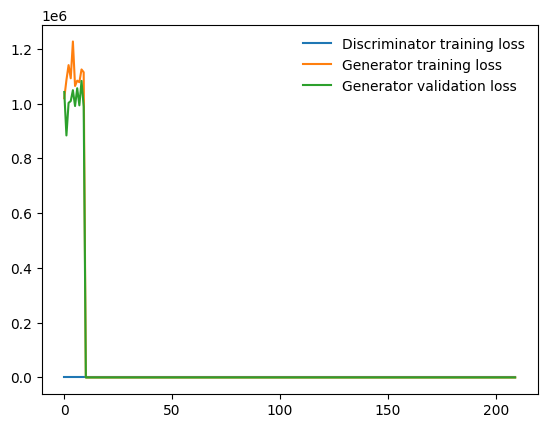

In [ ]:
%matplotlib inline
%config InlineBackend.figure.format = 'retina'

d_losses = [x[0] for x in losses]
g_losses = [x[1] for x in losses]
plt.plot(d_losses, label='Discriminator training loss')
plt.plot(g_losses, label='Generator training loss')
plt.plot(validation_losses, label='Generator validation loss')
plt.legend(frameon=False)

In [ ]:
checkpoint_generator = torch.load(checkpoint_dir + '/generator_latest.pth', map_location=torch.device(device))
G_inference_generator = Generator()
G_inference_generator.load_state_dict(checkpoint_generator['g_state_dict'])

<All keys matched successfully>

In [ ]:
checkpoint_best = torch.load(checkpoint_dir + '/checkpoint_epoch_086.pth', map_location=torch.device(device))
G_inference_best = Generator()
G_inference_best.load_state_dict(checkpoint_best['g_state_dict'])

<All keys matched successfully>

In [ ]:
G_inference_generator.to(device)
G_inference_best.to(device)
G.to(device)

Generator(
  (conv_1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res): Sequential(
    (0): ResidualBlock(
      (conv_1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm_1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

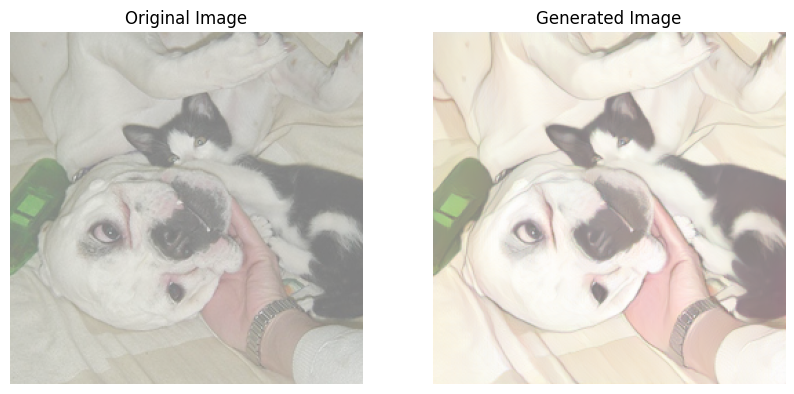

In [ ]:
test_images = next(iter(photo_dataloader_valid))[0].to(device)

with torch.no_grad():
    result_images_best_checkpoint = G_inference_generator(test_images)

# Original Image
original_image_to_show = test_images[0].cpu()
original_image_to_show = (original_image_to_show + 1) / 2
original_image_to_show = original_image_to_show.clamp(0, 1)
original_image_to_show = np.transpose(original_image_to_show.numpy(), (1, 2, 0))

# Generated Image
generated_image_to_show = result_images_best_checkpoint[0].cpu()
generated_image_to_show = (generated_image_to_show + 1) / 2
generated_image_to_show = generated_image_to_show.clamp(0, 1)
generated_image_to_show = np.transpose(generated_image_to_show.numpy(), (1, 2, 0))

# Display the images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_image_to_show)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(generated_image_to_show)
axes[1].set_title("Generated Image")
axes[1].axis('off')

plt.show()